## Importación de librerías

In [2]:
# Librerías para cálculos y visualización
# SEMILLA REPRODUCIBLE
import numpy as np
np.random.seed(42)

# Librerías para cálculos y visualización
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Importar tu motor de red neuronal
from src.network import NeuralNetwork
from src.dense import Dense
from src.activations import ReLU, Softmax
from src.losses import CrossEntropyLoss
from src.optimizer import Adam
from src.trainer import Trainer



Importamos librerías necesarias y tu implementación propia de la red.

## Cargar y preparar MNIST 

In [3]:
# Descargar MNIST desde OpenML
mnist = fetch_openml('mnist_784', version=1, cache=True)
X, y = mnist["data"], mnist["target"].astype(np.int64)

# Convertir a NumPy (MUY IMPORTANTE)
X = X.to_numpy()
y = y.to_numpy()

# Normalizar imágenes a [0,1]
X = X / 255.0

# Dividir en train (60%), val (20%), test (20%)
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Shapes:")
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Shapes:
Train: (42000, 784)
Val:   (14000, 784)
Test:  (14000, 784)


Se cargan y normalizan las imágenes.

## Codificar etiquetas a one-hot


In [10]:
encoder = OneHotEncoder(sparse_output=False)

y_train_oh = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_oh   = encoder.transform(y_val.reshape(-1, 1))
y_test_oh  = encoder.transform(y_test.reshape(-1, 1))

print("Shapes OHE:", y_train_oh.shape, y_val_oh.shape, y_test_oh.shape)


Shapes OHE: (42000, 10) (14000, 10) (14000, 10)


Tu Trainer requiere que las etiquetas sean one-hot.

## Crear la red neuronal y el trainer


In [11]:
network = NeuralNetwork([
    Dense(784, 128, initialization="he"),
    ReLU(),
    Dense(128, 10, initialization="xavier"),
    Softmax()
])

loss_fn = CrossEntropyLoss()

# Adam con L2 (weight_decay=1e-4)  ← NUEVO
optimizer = Adam(lr=0.001, weight_decay=1e-4)

# Trainer con early stopping (patience=6)  ← NUEVO
trainer = Trainer(network, optimizer, loss_fn, patience=6, verbose=True)

print("Red inicializada correctamente.")


Red inicializada correctamente.


Se define la arquitectura y se crea el entrenador.

## Entrenamiento durante 30 épocas


In [12]:
history = trainer.train(
    X_train, y_train_oh,
    X_val,   y_val_oh,
    epochs=30,
    batch_size=64
)


Epoch 1/30 - TrainLoss=0.3476 - ValLoss=0.1945 - ValAcc=0.9439
Epoch 2/30 - TrainLoss=0.1594 - ValLoss=0.1374 - ValAcc=0.9607
Epoch 3/30 - TrainLoss=0.1148 - ValLoss=0.1318 - ValAcc=0.9595
Epoch 4/30 - TrainLoss=0.0892 - ValLoss=0.1045 - ValAcc=0.9692
Epoch 5/30 - TrainLoss=0.0729 - ValLoss=0.0990 - ValAcc=0.9709
Epoch 6/30 - TrainLoss=0.0598 - ValLoss=0.0945 - ValAcc=0.9720
Epoch 7/30 - TrainLoss=0.0503 - ValLoss=0.0982 - ValAcc=0.9702
Epoch 8/30 - TrainLoss=0.0432 - ValLoss=0.0876 - ValAcc=0.9729
Epoch 9/30 - TrainLoss=0.0365 - ValLoss=0.0857 - ValAcc=0.9734
Epoch 10/30 - TrainLoss=0.0326 - ValLoss=0.0843 - ValAcc=0.9741
Epoch 11/30 - TrainLoss=0.0287 - ValLoss=0.0802 - ValAcc=0.9764
Epoch 12/30 - TrainLoss=0.0265 - ValLoss=0.0870 - ValAcc=0.9747
Epoch 13/30 - TrainLoss=0.0232 - ValLoss=0.0827 - ValAcc=0.9751
Epoch 14/30 - TrainLoss=0.0224 - ValLoss=0.0820 - ValAcc=0.9758
Epoch 15/30 - TrainLoss=0.0199 - ValLoss=0.0826 - ValAcc=0.9763
Epoch 16/30 - TrainLoss=0.0183 - ValLoss=0.0924 -

Entrenamos 30 épocas con batch size 64.
El history guarda pérdida y precisión para gráficas.

## Graficar pérdida y precisión


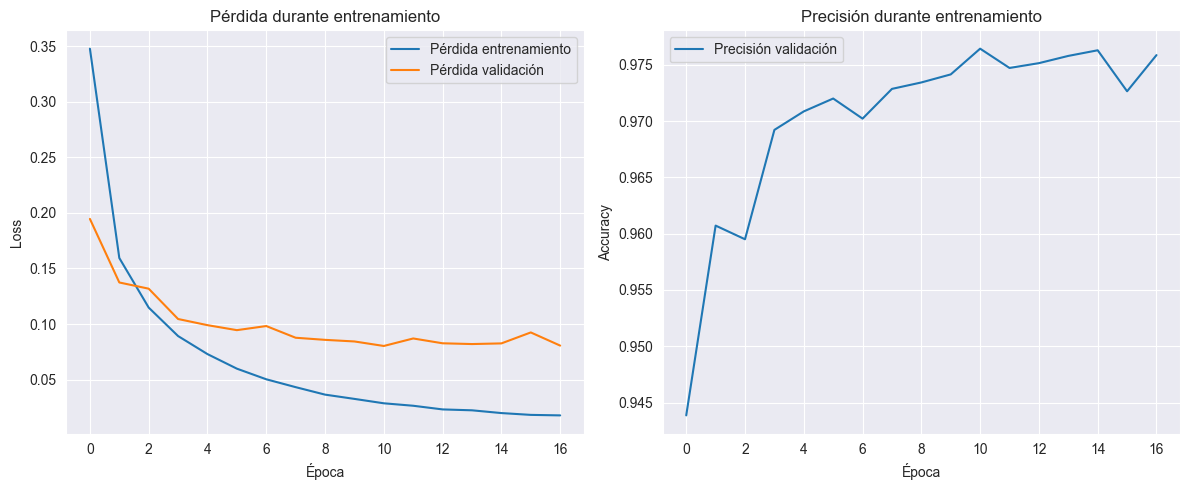

In [13]:
# Graficar pérdida y precisión
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Pérdida entrenamiento")
plt.plot(history["val_loss"], label="Pérdida validación")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida durante entrenamiento")
plt.legend()

# Precisión
plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Precisión validación")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Precisión durante entrenamiento")
plt.legend()

plt.tight_layout()
plt.show()


Se visualizan las métricas de entrenamiento por época.

## Evaluación final en test set


In [14]:
test_pred = network.forward(X_test)
test_loss = loss_fn.forward(test_pred, y_test_oh)
test_acc = np.mean(np.argmax(test_pred, axis=1) == np.argmax(y_test_oh, axis=1))

print(f"Pérdida en test: {test_loss:.4f}, Precisión en test: {test_acc:.4f}")


Pérdida en test: 0.0814, Precisión en test: 0.9768


Obtenemos métricas finales para la memoria.

## Guardar gráfica para la memoria


Gráfica guardada como 'resultados_entrenamiento.png'.


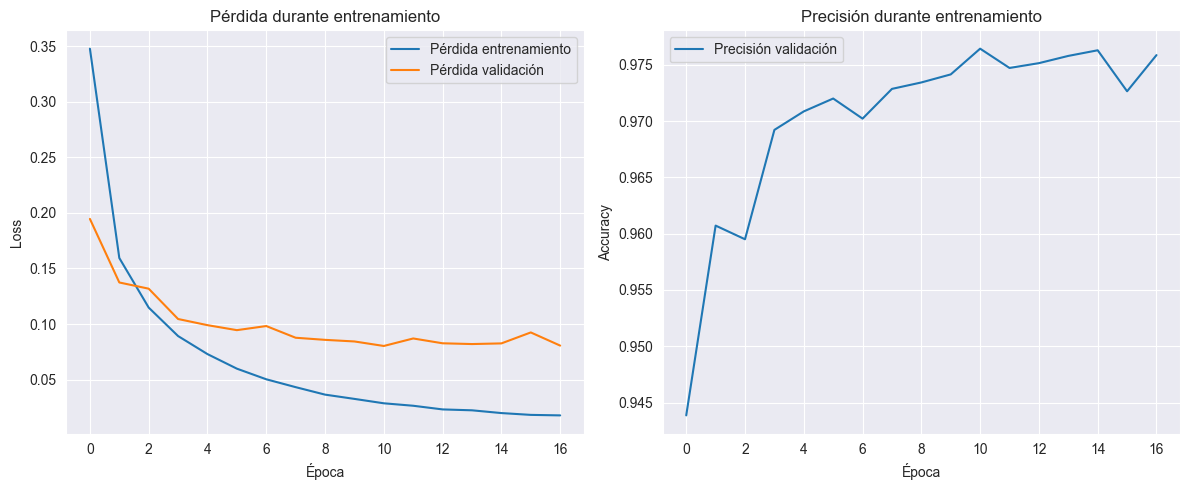

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Pérdida entrenamiento")
plt.plot(history["val_loss"], label="Pérdida validación")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida durante entrenamiento")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="Precisión validación")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Precisión durante entrenamiento")
plt.legend()

plt.tight_layout()
plt.savefig("resultados_entrenamiento.png")
print("Gráfica guardada como 'resultados_entrenamiento.png'.")


Guardamos la figura para usar en la memoria del proyecto.

## Matriz de confusión


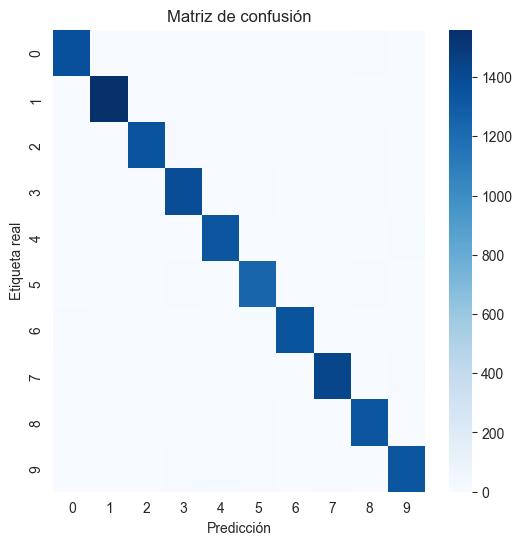

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.argmax(y_test_oh, axis=1)
y_pred = np.argmax(test_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.show()
